# BATS

## Imports

In [1]:
import torch
import librosa
import evaluate
import numpy as np
import gradio as gr
import librosa.display
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
from datasets import load_dataset, Audio
from typing import Any, Dict, List, Optional, Union
from transformers import AutoProcessor, AutoModelForCTC, TrainingArguments, Trainer, pipeline

In [ ]:
from src.data.dataset import CommonVoice
from src.data.vocab import SimpleVocab
from src.training.early_stopping import EarlyStopping
from src.training.train import train_model
from src.training.evaluate import evaluate_model

## Data

### Download Dataset

In [2]:
stream = False # True for streaming and load the data progressively, False for non-streaming and load the entire dataset

cv_11_train = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="train", streaming=stream) #Common Voice 11.0

/Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


### Dataset Info

In [5]:
cv_11_train

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 948736
})

### Dataset Keys

In [7]:
cv_11_train[0].keys()

dict_keys(['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'])

### Sentence

In [10]:
cv_11_train[0]['sentence']

'The track appears on the compilation album "Kraftworks".'

### Audio Keys

In [11]:
cv_11_train[0]['audio'].keys()

dict_keys(['path', 'array', 'sampling_rate'])

### Array Data

In [12]:
cv_11_train[0]['audio']['array']

array([ 0.00000000e+00,  1.96611932e-15, -7.55339395e-14, ...,
        1.68718288e-05,  1.41906639e-07,  1.16676732e-04])

### Sampling Rate

In [13]:
cv_11_train[0]['audio']['sampling_rate']

48000

### Prepare Data (Maybe Optional)

In [3]:
def prepare_dataset(batch):
  """Function to preprocess the dataset with the .map method"""
  transcription = batch["sentence"]
  
  if transcription.startswith('"') and transcription.endswith('"'):
    # we can remove trailing quotation marks as they do not affect the transcription
    transcription = transcription[1:-1]
  
  if transcription[-1] not in [".", "?", "!"]:
    # append a full-stop to sentences that do not end in punctuation
    transcription = transcription + "."
  
  batch["sentence"] = transcription
  
  return batch

In [4]:
columns_to_remove = ['client_id', 'path', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment']

ds_train = cv_11_train.map(prepare_dataset, desc="preprocess dataset")
ds_train_cleaned = ds_train.remove_columns(columns_to_remove)

ds_train_cleaned

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 948736
})

In [16]:
ds_train_cleaned[0]['audio']

{'path': '/Users/diego/.cache/huggingface/datasets/downloads/extracted/4a1a08aa90abb7311bc8a73254d116a4730ea3116c079eb3b7193c2040cc2bd6/en_train_0/common_voice_en_19121553.mp3',
 'array': array([ 0.00000000e+00,  1.96611932e-15, -7.55339395e-14, ...,
         1.68718288e-05,  1.41906639e-07,  1.16676732e-04]),
 'sampling_rate': 48000}

In [17]:
ds_train_cleaned[0]['sentence']

'The track appears on the compilation album "Kraftworks".'

### Listen Audios

In [18]:
def generate_audio(dataset):
    example = dataset.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), example["sentence"]

In [ ]:
with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio(ds_train_cleaned)
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

### Visualize Data

In [5]:
array = ds_train_cleaned[0]['audio']['array']
sampling_rate = ds_train_cleaned[0]['audio']['sampling_rate']

In [12]:
ds_train_cleaned[0]['sentence']

'The track appears on the compilation album "Kraftworks".'

### Waveform

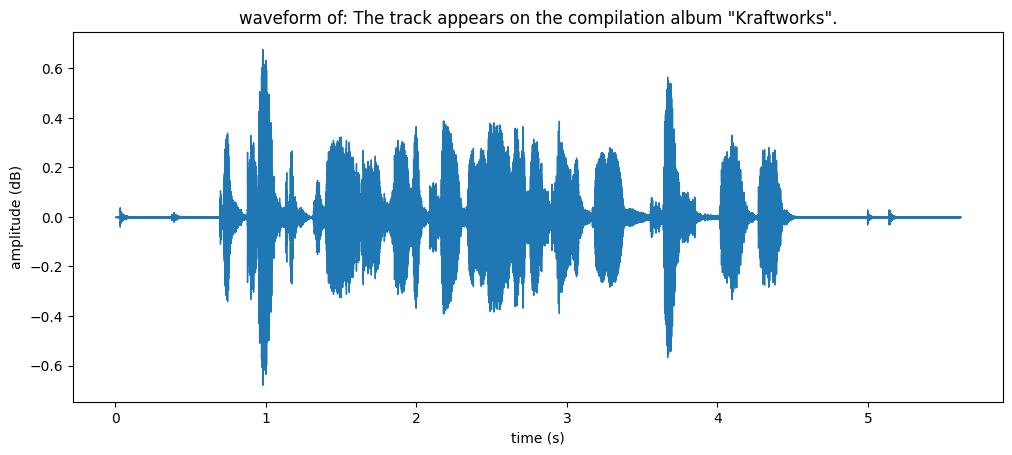

In [13]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)
plt.title(f"waveform of: {ds_train_cleaned[0]['sentence']}")
plt.xlabel("time (s)")
plt.ylabel("amplitude (dB)")
plt.show()

### Frequency Spectrum

In [46]:
dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

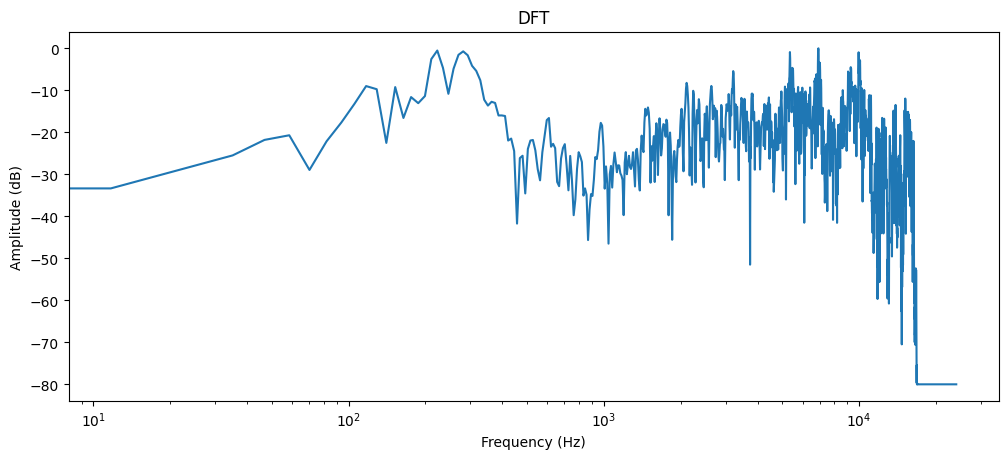

In [47]:
plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")
plt.title("DFT")
plt.show()

### Spectrogram

In [14]:
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

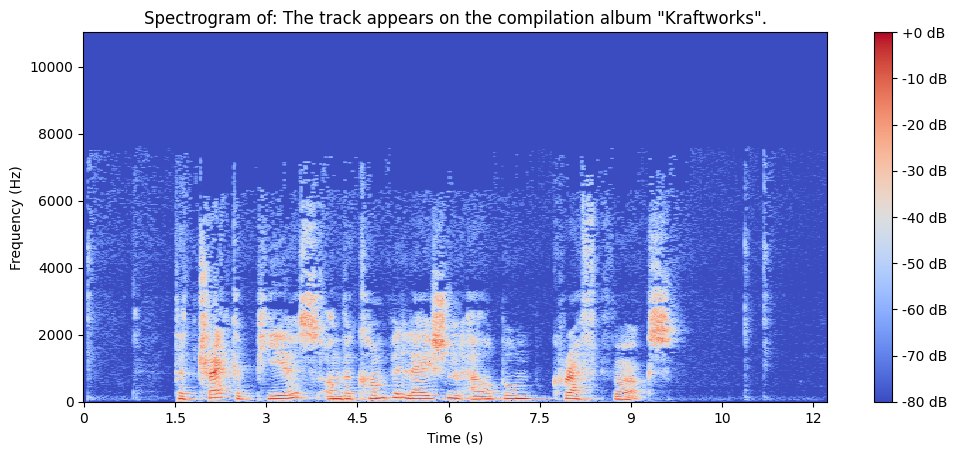

In [44]:
plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz", cmap="coolwarm")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of: " + ds_train_cleaned[0]['sentence'])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

### Mel Spectrogram

In [22]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=80, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

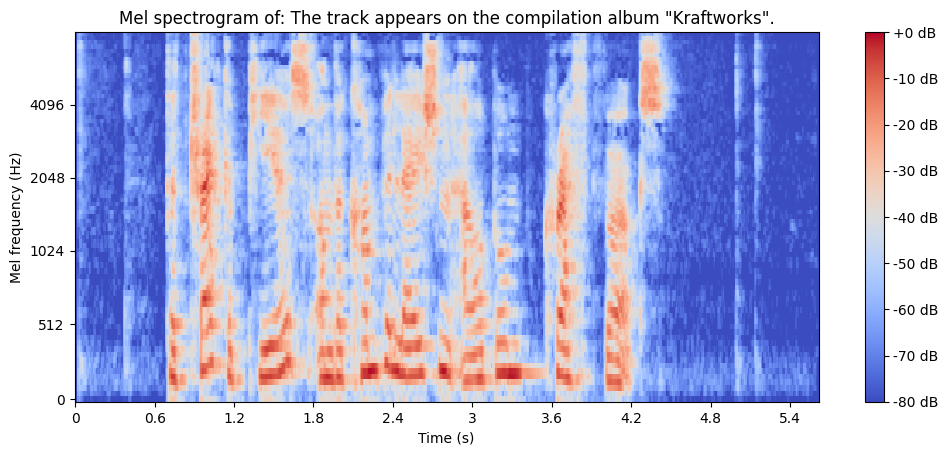

In [43]:
plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000, cmap='coolwarm')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel spectrogram of: " + ds_train_cleaned[0]['sentence'])
plt.xlabel("Time (s)")
plt.ylabel("Mel frequency (Hz)")
plt.show()

### Mel Cepstrum Coefficients (MFCCs)

In [26]:
mfccs = librosa.feature.mfcc(y=array, sr=sampling_rate, n_mfcc=80)
#mfccs_dB = librosa.power_to_db(mfccs, ref=np.max)

Text(0.5, 1.0, 'MFCCs')

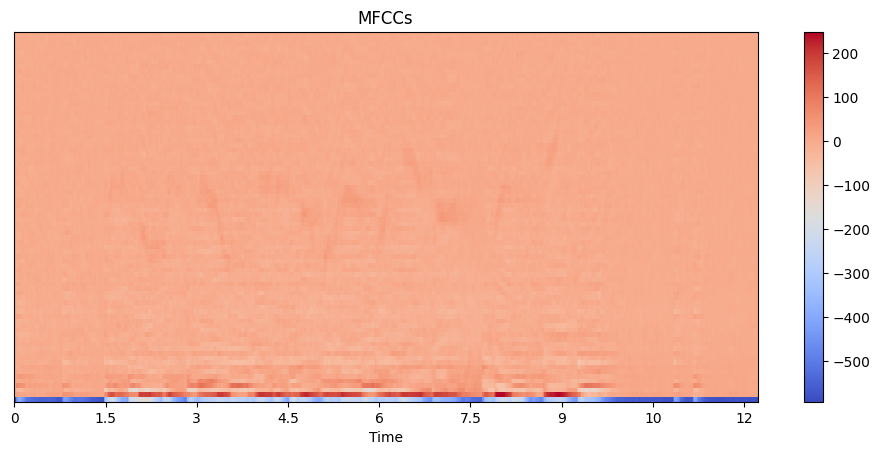

In [27]:
plt.figure().set_figwidth(12)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.title("MFCCs")

### Resampling Audio

In [28]:
ds_resampled = ds_train_cleaned.cast_column("audio", Audio(sampling_rate=16_000))
ds_resampled[0]['audio']

{'path': '/Users/fcisternas/.cache/huggingface/datasets/downloads/extracted/13c54c5a6c27bff3d83430023e3217387f27a2958fce045789b191f39ed3391b/en_train_0/common_voice_en_19121553.mp3',
 'array': array([-3.49245965e-10, -2.32830644e-10, -2.32830644e-10, ...,
        -5.81124914e-05, -2.75571656e-05,  2.96055368e-05]),
 'sampling_rate': 16000}

### Preprocessing

In [29]:
processor = AutoProcessor.from_pretrained("openai/whisper-tiny")

#feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small") #whisper feature extractor

### UpperCase and LowerCase 

In [30]:
def uppercase(example):
    return {"labels": example["sentence"].upper()}

def lowercase(example):
    return {"labels": example["sentence"].lower()}

In [31]:
ds_resampled

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 948736
})

In [194]:
ds_lowercase = ds_resampled.map(lowercase, remove_columns='sentence', num_proc=4)

Map (num_proc=4):   0%|          | 0/948736 [00:00<?, ? examples/s]

In [195]:
ds_lowercase

Dataset({
    features: ['audio', 'labels'],
    num_rows: 948736
})

In [192]:
ds_lowercase[0]['labels']

'the track appears on the compilation album "kraftworks".'

### Feature Extractor

In [32]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch = processor(audio["array"], sampling_rate=audio["sampling_rate"], text=batch["labels"], padding=False)
    batch["input_length"] = len(audio["array"]) / audio["sampling_rate"]
    return batch

In [ ]:
#ds_prep = ds_lowercase.map(prepare_dataset, num_proc=8) # too long

In [33]:
example = ds_resampled[0]
example

{'audio': {'path': '/Users/fcisternas/.cache/huggingface/datasets/downloads/extracted/13c54c5a6c27bff3d83430023e3217387f27a2958fce045789b191f39ed3391b/en_train_0/common_voice_en_19121553.mp3',
  'array': array([-3.49245965e-10, -2.32830644e-10, -2.32830644e-10, ...,
         -5.81124914e-05, -2.75571656e-05,  2.96055368e-05]),
  'sampling_rate': 16000},
 'sentence': 'The track appears on the compilation album "Kraftworks".'}

In [34]:
example['labels'] = lowercase(example)['labels']
example.pop('sentence')
example

{'audio': {'path': '/Users/fcisternas/.cache/huggingface/datasets/downloads/extracted/13c54c5a6c27bff3d83430023e3217387f27a2958fce045789b191f39ed3391b/en_train_0/common_voice_en_19121553.mp3',
  'array': array([-3.49245965e-10, -2.32830644e-10, -2.32830644e-10, ...,
         -5.81124914e-05, -2.75571656e-05,  2.96055368e-05]),
  'sampling_rate': 16000},
 'labels': 'the track appears on the compilation album "kraftworks".'}

In [35]:
example.keys()

dict_keys(['audio', 'labels'])

In [36]:
print(example['audio']['array'])
print(example['audio']['sampling_rate'])
print(example['labels'])

[-3.49245965e-10 -2.32830644e-10 -2.32830644e-10 ... -5.81124914e-05
 -2.75571656e-05  2.96055368e-05]
16000
the track appears on the compilation album "kraftworks".


In [37]:
example_prep = prepare_dataset(example)
example_prep.keys()

dict_keys(['input_features', 'labels', 'input_length'])

In [38]:
print(example_prep['input_features'])
print(example_prep['input_length'])
print(example_prep['labels'])

[array([[-0.7125063 , -0.7125063 , -0.6029564 , ..., -0.7125063 ,
        -0.7125063 , -0.7125063 ],
       [-0.7125063 , -0.7125063 , -0.5964241 , ..., -0.65036845,
        -0.6294527 , -0.6667937 ],
       [-0.7125063 , -0.7125063 , -0.46625304, ..., -0.45396256,
        -0.4914949 , -0.57323146],
       ...,
       [-0.7125063 , -0.7125063 , -0.42880678, ..., -0.6953063 ,
        -0.6744189 , -0.7125063 ],
       [-0.7125063 , -0.7125063 , -0.5773828 , ..., -0.6806394 ,
        -0.7125063 , -0.7125063 ],
       [-0.7125063 , -0.7125063 , -0.59138274, ..., -0.7125063 ,
        -0.7125063 , -0.7125063 ]], dtype=float32)]
5.616
[50258, 50363, 3322, 220, 19466, 7038, 322, 220, 3322, 40261, 6030, 503, 47288, 18357, 1883, 50257]


In [ ]:
 example_prep["labels"][0]

In [39]:
input_features = example_prep["input_features"][0]

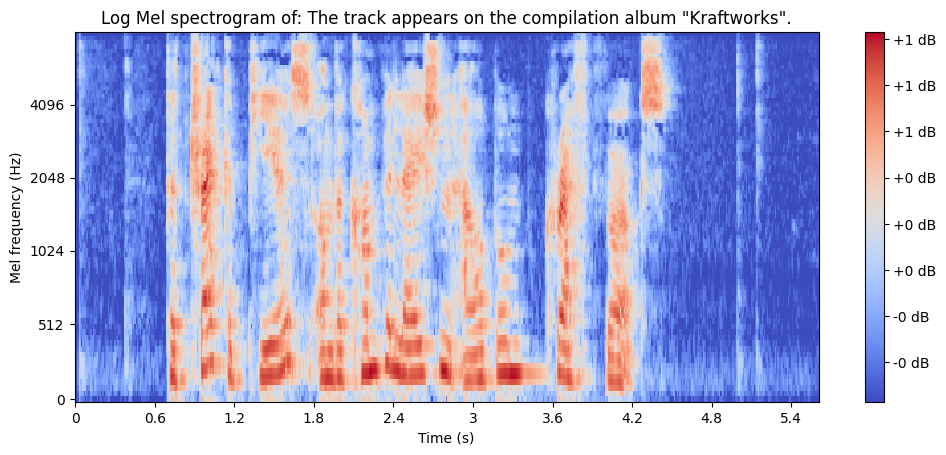

In [42]:
plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features),
    x_axis="time",
    y_axis="mel",
    sr=processor.feature_extractor.sampling_rate,
    hop_length=processor.feature_extractor.hop_length,
)
plt.colorbar(format="%+2.0f dB")
plt.title("Log Mel spectrogram of: " + ds_train_cleaned[0]['sentence'])
plt.xlabel("Time (s)")
plt.ylabel("Mel frequency (Hz)")
plt.show()

### Convert to Pytorch Dataset

In [167]:
ds_pytorch = ds_resampled.with_format("torch")
#ds_pytorch = ds_prep.with_format("torch") 

ds_pytorch

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 948736
})

In [172]:
print(ds_pytorch[0]['audio']['array'])
print(type(ds_pytorch[0]['audio']['array']))

tensor([-3.4925e-10, -2.3283e-10, -2.3283e-10,  ..., -5.8112e-05,
        -2.7557e-05,  2.9606e-05])
<class 'torch.Tensor'>


### Data Loader

In [173]:
dataloader = DataLoader(ds_pytorch, batch_size=32, num_workers=4)

In [ ]:
train_loader = #TODO
val_loader = #TODO

**From Here we can take 2 approaches, use Hugginface API or use Pytorch API, here are the codes but i dont tested it**  

**TODO:** Test the code below

## Hugginface API

### Data Collator

In [179]:
@dataclass
class DataCollatorCTCWithPadding:
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_features": feature["input_features"][0]} for feature in features]

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.feature_extractor.pad(input_features, padding=self.padding, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(labels=label_features, padding=self.padding, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [180]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding="longest")

### Evaluate Metrics

In [225]:
wer = evaluate.load("wer") # load the WER metric (Word Error Rate)

In [226]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Huggginface Pre-trained Model

In [ ]:
model = AutoModelForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

### Training Args

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_asr_mind_model",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    group_by_length=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

### Trainer Init

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_loader,
    eval_dataset=val_loader,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### Train Model

In [ ]:
trainer.train()

### Inference with Hugginface

In [ ]:
dataset = load_dataset("PolyAI/minds14", "en-US", split="train")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = dataset.features["audio"].sampling_rate
audio_file = dataset[0]["audio"]["path"]

### Inference Pipeline

In [ ]:
transcriber = pipeline("automatic-speech-recognition", model="stevhliu/my_awesome_asr_minds_model")
transcriber(audio_file)

## Pytorch API

### Pytorch Model

In [10]:
# Modelo RNN simple
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

### Init Model

In [ ]:
# Instanciar modelo, función de pérdida y optimizador
input_size = #TODO
hidden_size = #TODO
output_size = #TODO
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

In [ ]:
# Funciones de entrenamiento y validación
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, output_size), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, output_size), labels.view(-1))
            running_loss += loss.item()
    return running_loss / len(val_loader)

# Entrenamiento
num_epochs = 3
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate_epoch(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


### Manual Pipeline with Pytorch

In [ ]:
processor = AutoProcessor.from_pretrained("stevhliu/my_awesome_asr_mind_model")
inputs = processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

In [ ]:
model = AutoModelForCTC.from_pretrained("stevhliu/my_awesome_asr_mind_model")
with torch.no_grad():
    logits = model(**inputs).logits

In [ ]:
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)
transcription